In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from tqdm.notebook import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import xgboost
from datetime import date
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import matplotlib as mpl
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline
warnings.filterwarnings('ignore')

data_path = '../input/9a42e96ae39ddaf9596a6dd6c2bd77c7/'

train = pd.read_csv(data_path + 'train.csv', parse_dates=['date']) # date column을 object type이 아닌 datetime으로
test = pd.read_csv(data_path + 'test.csv', parse_dates=['date'])
products = pd.read_csv(data_path + 'product.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

#### 채점 방식 : SMAPE
![smape_wiki](https://wikimedia.org/api/rest_v1/media/math/render/svg/e5eab10e691bead6d1d175a370546db3f4371507)

In [2]:
def SMAPE(true, pred):
    '''
    true: np.array 
    pred: np.array
    '''
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))*100

# 1. 데이터 탐색

### 1.1 Train, Test Data 살펴보기

In [3]:
# train 데이터의 날짜 min, max
print("Min date from train set :", train['date'].min().date())
print("Max date from train set :", train['date'].max().date())

Min date from train set : 2018-01-02
Max date from train set : 2021-12-31


In [4]:
# test 데이터의 날짜 min, max와 lag 파악
lag_size = (test['date'].max().date() - test['date'].min().date()).days
print("Min test from train set :", test['date'].min().date())
print("Max test from train set :", test['date'].max().date())
print("Forecast lag size:", lag_size)

Min test from train set : 2022-01-03
Max test from train set : 2022-03-31
Forecast lag size: 87


In [5]:
# 상품 구분없이 보는 sales
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
daily_sales.head()

,date,sales
0,2018-01-02,20009803.0
1,2018-01-03,23845247.0
2,2018-01-04,23796326.0
3,2018-01-05,21188551.0
4,2018-01-08,21861024.0


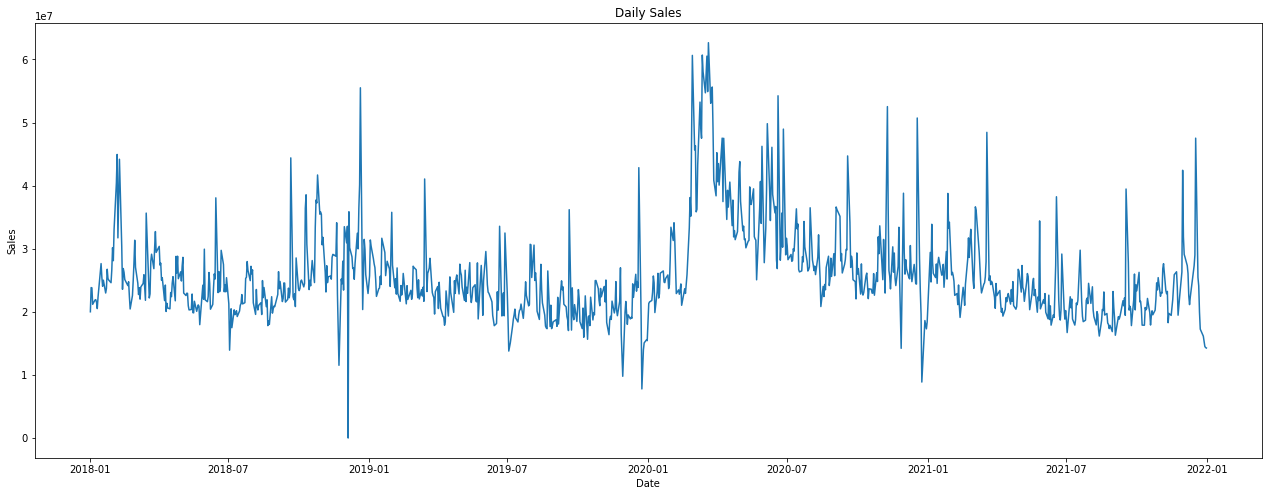

In [6]:
# 일자별 상품 판매량 추이그래프
plt.figure(figsize=(22,8))
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title("Daily Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show();

* 18년도 말에 크게 튀는 값이 있는 것이 특징.
* 20년도 초에 크게 증가했다가 점차 감소하는 경향을 보였음

### 1.2 Product Category
* 간단하게 몇 가지 동일 카테고리별로 그래프를 그려서 어느정도 비슷한 경향이 있는 지에 대해서 살펴보기

#### __Category Cat_1__

In [7]:
id_date = train.groupby(['date','product_id'])['sales'].sum().unstack()
# 모든 동일한 category 가진 상품들 최대 6개까지만 그래프 출력 --------------------------> 시각적으로 확인했을 때는 category 같다고해서 같은 경향성을 나타내진 않았음
for o,i in enumerate(list(products['cat_1'].unique())):
    if o > 2:
        break
    fig = px.area(id_date[list(products[products['cat_1']==i]['product_id'])].loc[:,:list(products[products['cat_1']==i]['product_id'])[:6][-1]], facet_col="product_id", facet_col_wrap=2, title=f'cat_1 : {i}')
    fig.show()

#### __Category Cat_2__

In [8]:
for o,i in enumerate(list(products['cat_2'].unique())):
    if o > 2:
        break
    fig = px.area(id_date[list(products[products['cat_2']==i]['product_id'])].loc[:,:list(products[products['cat_2']==i]['product_id'])[:6][-1]], facet_col="product_id", facet_col_wrap=2, title=f'cat_2 : {i}')
    fig.show()

#### __Category Cat_sum__
* cat_1, cat_2 두개가 모두 동일한 상품들

In [9]:
products['cat_sum'] = products['cat_1']+products['cat_2']
for o,i in enumerate(list(products['cat_sum'].unique())):
    if o > 2:
        break
    fig = px.area(id_date[list(products[products['cat_sum']==i]['product_id'])].loc[:,:list(products[products['cat_sum']==i]['product_id'])[:6][-1]], facet_col="product_id", facet_col_wrap=2, title=f'cat_sum : {i}')
    fig.show()

* 단순한 카테고리별 분류로는 비슷한 경향을 볼 수 있는 것을 알 수가 없었음
* 특이사항으로는 product_id = 43 은 2021년부터 데이터가 생성되었으며 product_id = 350 은 232개의 데이터가 '0'이었다.

In [10]:
# 특이사항 데이터인 43과 350의 그래프
df = id_date[[43,350]].reset_index()
fig = px.line(df, x="date", y=df.columns,
    hover_data={"date": "|%B %d, %Y"},
    title='특이사항 데이터 43과 350의 그래프')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

### 1.3 Stationarity & Seasonality
* 정상성과 계절성 확인
* 차분과 로그변환 이후 아리마 모델 테스트를 통해서 이후 진행방향 확인하기

product_id :184


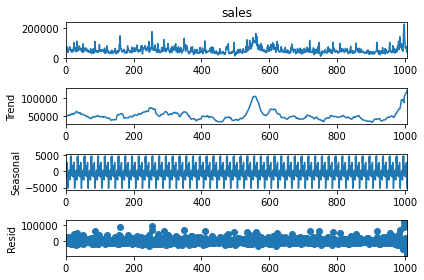

In [11]:
import random

# 셀 실행마다 다른 상품의 정보를 보도록 설정하였음.
target_product_id = random.randint(1, len(train['product_id'].unique()))
print(f"product_id :{target_product_id}")
temp_data = train[train['product_id']==target_product_id].reset_index(drop=True)
decompose = seasonal_decompose(temp_data.sales, model='additive', two_sided=True, 
                            period=20, extrapolate_trend='freq')
decompose.plot()
plt.show()

In [12]:
# 특정된 상품의 날짜와 기간 살펴보기
temp_data_lag_size = (temp_data['date'].max().date() - temp_data['date'].min().date()).days
print("Min date from temp_data :", temp_data['date'].min().date())
print("Max date from temp_data :", temp_data['date'].max().date())
print("temp data lag size :",temp_data_lag_size)

Min date from temp_data : 2018-01-02
Max date from temp_data : 2021-12-31
temp data lag size : 1459


In [13]:
lag_2018 = temp_data[temp_data['date']<'2019'].shape[0]
lag_2018

251

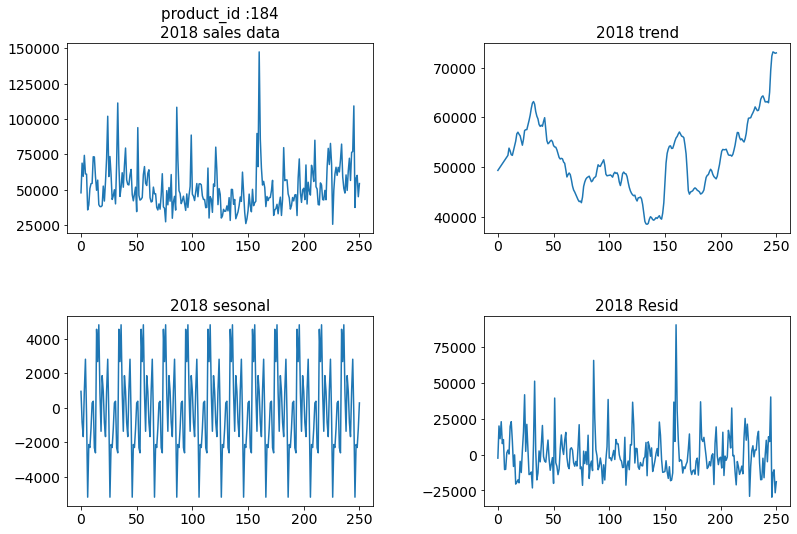

In [14]:
mpl.rc('font', size=14)                          # 폰트크기 설정
mpl.rc('axes', titlesize=15)                     # 제목 크기 설정
figure, axes = plt.subplots(nrows=2, ncols=2)    # subplot 2행 2열
plt.tight_layout()                               # subplot 간격 벌리기
figure.set_size_inches(12, 8)                    # subplot 크기 설정

decompose.observed[:lag_2018].plot(ax=axes[0,0])
decompose.trend[:lag_2018].plot(ax=axes[0,1])
decompose.seasonal[:lag_2018].plot(ax=axes[1,0])
decompose.resid[:lag_2018].plot(ax=axes[1,1])

# 차트에 이름 설정
axes[0,0].set(title=f'product_id :{target_product_id}\n2018 sales data')
axes[0,1].set(title='2018 trend')
axes[1,0].set(title='2018 sesonal')
axes[1,1].set(title='2018 Resid');

* __Trend는 product마다 다른 경향을 보여줬지만 seasonal의 경우 대체적으로 비슷한 양상을 보여주었다.__
* __Trend가 존재하기 때문에 정상성 X__
* __log변환과 차분을 통해서 trend를 죽여준다.__

# 2. ARIMA 결과 살펴보기
* log변환과 차분을 통해서 trend를 최대한 줄이고 ARIMA모델에 넣어서 stationary해지는 지 확인한 후에 ARIMA모델을 사용할 것인 지에 대해서 살펴보기

In [15]:
# 차분
temp_data['diff_sales'] = temp_data['sales'].diff(periods=1).iloc[1:]

In [16]:
temp_data = temp_data.fillna(0)

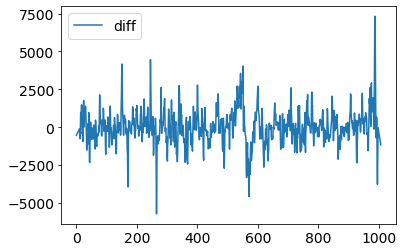

In [17]:
seasonal_decompose(temp_data.diff_sales, model='additive', two_sided=True, 
                            period=20, extrapolate_trend='freq').trend.plot(label='diff')

plt.legend();

In [18]:
adfuller(temp_data.diff_sales)

(-14.7947517563002,
 2.1441220945584697e-27,
 10,
 997,
 {'1%': -3.4369259442540416,
  '5%': -2.8644432969122833,
  '10%': -2.5683158550174094},
 22061.463268238338)

> 두번째 값인 p-value가 0.05보다 매우 작기 때문에 귀무가설(안정적이지 않다)를 기각  
이후 ARIMA모델까지 진행

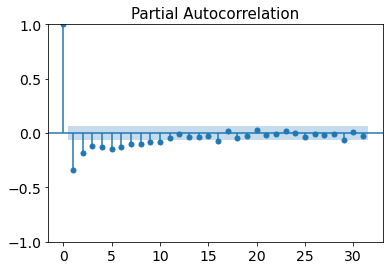

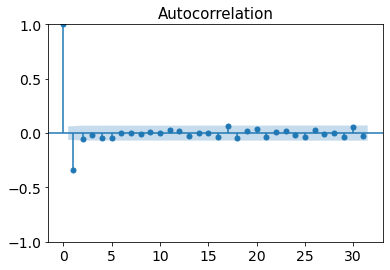

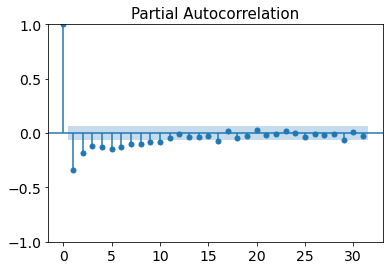

In [19]:
plot_acf(temp_data.diff_sales)
plot_pacf(temp_data.diff_sales)

값이 약간의 변하는건 있지만 어느정도 stable하다.

In [20]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(temp_data, test_size = 0.2, shuffle = False)

In [21]:
train_df = train_df[['date','diff_sales']]
test_df = test_df[['date','diff_sales']]

In [22]:
from statsmodels.tsa.arima.model import ARIMA
model =ARIMA(train_df.diff_sales, seasonal_order = (1,0,1,2), trend='n')
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:              diff_sales   No. Observations:                  806
Model:             ARIMA(1, 0, [1], 2)   Log Likelihood               -9098.998
Date:                 Tue, 29 Nov 2022   AIC                          18203.997
Time:                         04:54:14   BIC                          18218.073
Sample:                              0   HQIC                         18209.403
                                 - 806                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L2        0.3773      0.285      1.323      0.186      -0.182       0.936
ma.S.L2       -0.4711      0.277     -1.699      0.089      -1.014       0.072
sigma2      3.751e+08   1.19e-09   3.14e+17      0.000    3.75e+08    3.75e+08
===================================================================================
Ljung-Box (L1) (Q):                 132.08   Jarque-Bera (JB):               453.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.39
Prob(H) (two-sided):                  0.41   Kurtosis:                         6.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+35. Standard errors may be unstable.
"""

In [23]:
# Parameter search
import itertools

p = range(0,3)
d = range(0,3)
q = range(0,3)
s = range(2,3)
pdqs = list(itertools.product(p, d,q,s))

aic = []
for i in pdqs:
    model = ARIMA(train_df.diff_sales, seasonal_order = (i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC : {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))
    
# Search optimal parameters
optimal = [(pdqs[i],j) for i, j in enumerate(aic) if j == min(aic)]
optimal

ARIMA: (0, 0, 0, 2) >> AIC : 22799.04
ARIMA: (0, 0, 1, 2) >> AIC : 18206.04
ARIMA: (0, 0, 2, 2) >> AIC : 18205.76
ARIMA: (0, 1, 0, 2) >> AIC : 18785.35
ARIMA: (0, 1, 1, 2) >> AIC : 18177.17
ARIMA: (0, 1, 2, 2) >> AIC : 18172.97
ARIMA: (0, 2, 0, 2) >> AIC : 19629.51
ARIMA: (0, 2, 1, 2) >> AIC : 18793.14
ARIMA: (0, 2, 2, 2) >> AIC : 18441.26
ARIMA: (1, 0, 0, 2) >> AIC : 18206.74
ARIMA: (1, 0, 1, 2) >> AIC : 18206.0
ARIMA: (1, 0, 2, 2) >> AIC : 18207.62
ARIMA: (1, 1, 0, 2) >> AIC : 18539.48
ARIMA: (1, 1, 1, 2) >> AIC : 18211.43
ARIMA: (1, 1, 2, 2) >> AIC : 18184.28
ARIMA: (1, 2, 0, 2) >> AIC : 19151.91
ARIMA: (1, 2, 1, 2) >> AIC : 18508.03
ARIMA: (1, 2, 2, 2) >> AIC : 18312.53
ARIMA: (2, 0, 0, 2) >> AIC : 18206.09
ARIMA: (2, 0, 1, 2) >> AIC : 18207.55
ARIMA: (2, 0, 2, 2) >> AIC : 18208.79
ARIMA: (2, 1, 0, 2) >> AIC : 18432.07
ARIMA: (2, 1, 1, 2) >> AIC : 18206.91
ARIMA: (2, 1, 2, 2) >> AIC : 18185.28
ARIMA: (2, 2, 0, 2) >> AIC : 18921.76
ARIMA: (2, 2, 1, 2) >> AIC : 18504.29
ARIMA: (2, 2,

[((0, 1, 2, 2), 18172.97)]

In [24]:
model =ARIMA(train_df.diff_sales, seasonal_order = (1,2,2,2))
model_fit = model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                 diff_sales   No. Observations:                  806
Model:             ARIMA(1, 2, [1, 2], 2)   Log Likelihood               -9152.267
Date:                    Tue, 29 Nov 2022   AIC                          18312.534
Time:                            04:54:23   BIC                          18331.283
Sample:                                 0   HQIC                         18319.736
                                    - 806                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L2       -0.0875      0.060     -1.449      0.147      -0.206       0.031
ma.S.L2       -1.9667      0.024    -82.390      0.000      -2.013      -1.920
ma.S.L4        0.9669      0.024     40.648      0.000       0.920       1.014
sigma2      7.631e+08   5.17e-12   1.48e+20      0.000    7.63e+08    7.63e+08
===================================================================================
Ljung-Box (L1) (Q):                 122.76   Jarque-Bera (JB):               403.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             0.33
Prob(H) (two-sided):                  0.45   Kurtosis:                         6.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.62e+35. Standard errors may be unstable.
"""

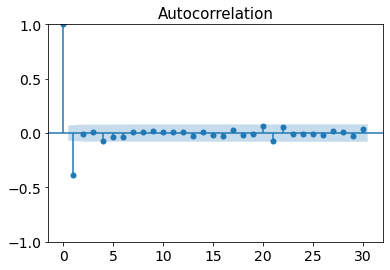

In [25]:
plot_acf(model_fit.resid)
plt.show()

도표 상으론 어느정도 stationary하다.

In [26]:
adfuller(model_fit.resid)

(-14.994503193956028,
 1.1128105356848329e-27,
 8,
 797,
 {'1%': -3.438581476199162,
  '5%': -2.865173218890781,
  '10%': -2.56870466056054},
 17536.390107111907)

p-value값이 0.05보다 매우 작아서 안정적이다.

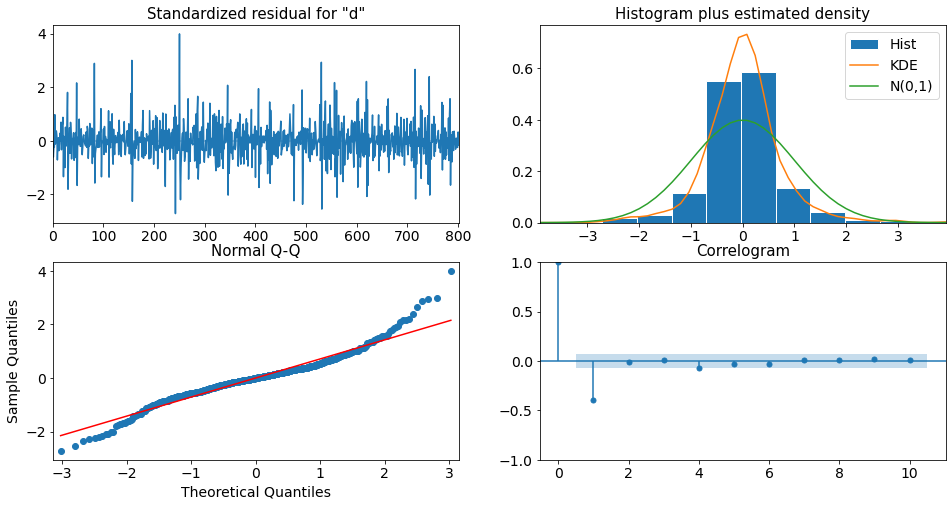

In [27]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

* 잔차는 평균 0을 기점으로 움직임
* Correlogram을 통해 어느정도 허용범위 안에 위치해있음
* Normal Q-Q plot을 보니 정규성에서는 약간 벗어난 것을 알 수 있음

In [28]:
result = model_fit.get_forecast(steps = len(test_df.index), alpha = 0.05).summary_frame()
result

diff_sales,mean,mean_se,mean_ci_lower,mean_ci_upper
806,-2004.770219,27624.105900,-56147.022887,52137.482450
807,1117.849723,27624.105900,-53024.402946,55260.102392
808,-1114.701922,27664.575963,-55336.274457,53106.870612
809,763.610438,27664.575963,-53457.962096,54985.182973
810,-1197.951990,27684.868278,-55459.296733,53063.392752
...,...,...,...,...
1003,1000.620386,30107.399460,-58008.798223,60010.038995
1004,-1670.046061,30146.240074,-60755.590876,57415.498753
1005,1002.768151,30146.240074,-58082.776664,60088.312967
1006,-1674.977978,30185.384227,-60837.243922,57487.287966


In [29]:
fc = tuple(result['mean'].values) # 예측값
se = tuple(result['mean_se'].values) # 표준오차
lower_coef = tuple(result['mean_ci_lower'].values) # 신뢰구간 최소
upper_coef = tuple(result['mean_ci_upper'].values) # 신뢰구간 최대

# 예측값 인덱스 넣기
fc_data = pd.Series(fc, index = test_df.index)

# 신뢰구간 인덱스 넣기
lower_data = pd.Series(lower_coef, index = test_df.index)
upper_data = pd.Series(upper_coef, index = test_df.index )

In [30]:
test_df

,date,diff_sales
806,2021-03-17,8079.0
807,2021-03-18,-1287.0
808,2021-03-19,53209.0
809,2021-03-22,-47115.0
810,2021-03-23,19517.0
...,...,...
1003,2021-12-27,-6639.0
1004,2021-12-28,8969.0
1005,2021-12-29,-38527.0
1006,2021-12-30,-1163.0


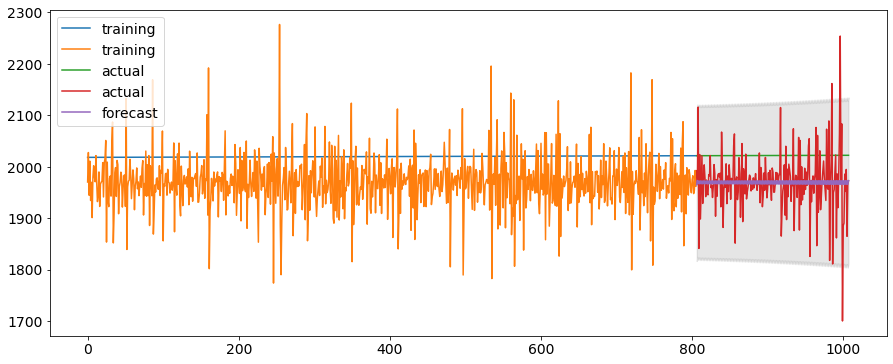

In [31]:
#시각화 
plt.figure(figsize =(15, 6))
plt.plot(train_df, label = 'training')
plt.plot(test_df, label = 'actual')
plt.plot(fc_data, label = 'forecast')
plt.fill_between(test_df.index, lower_data, upper_data, color = 'black', alpha = 0.1)
plt.legend(loc = 'upper left')
plt.show()

## 2.1 ARIMA 첫번째 시도
* train data를 통한 예측은 좋지 못한 결과를 나타내었다.
* 다른 변수를 활용한 방법이 좋을 것으로 판단된다.

## 2.2 ARIMA 두번째 방법
* 슬라이딩 윈도우 로직을 통한 예측
* 매 상품마다 p,d,q를 구하고 예측을 진행하기 때문에 상당히 오래 걸림

In [32]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.6 MB/s eta 0:00:00


In [33]:
from pmdarima.arima import ndiffs
import pmdarima as pm

y = train[train['product_id']==1]
y.drop(['product_id'],axis=1, inplace=True)
y = y.set_index('date')
y_train = y[:-89]
y_test = y[y_train.shape[0]:]

In [34]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


In [35]:
model = pm.auto_arima(y = y_train        # 데이터
                      , d = 1            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0 
                      , max_q = 3   
                      , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20205.401, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20066.574, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19922.433, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20203.402, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19878.871, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19877.364, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=19979.848, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=19870.053, Time=0.47 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=19966.148, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=19869.713, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19877.065, Time=0.23 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=19869.979, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=19865.799, Time=1.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=19883.500, Time=0.63 sec
 ARIMA(1,1,2)(0,0,0

In [36]:
model = pm.auto_arima(y_train, d = 1, seasonal = False, trace = True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19877.065, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20205.401, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20066.574, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19922.433, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20203.402, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19871.117, Time=0.70 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=19882.821, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19878.871, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=19883.500, Time=0.64 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=19881.658, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19877.364, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=19865.799, Time=1.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=19869.979, Time=0.61 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=19869.971, Time=0.90 sec
 ARIMA(1,1,4)(0,0,0

ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [37]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  919
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -9926.020
Date:                Tue, 29 Nov 2022   AIC                          19864.040
Time:                        04:55:00   BIC                          19892.973
Sample:                             0   HQIC                         19875.082
                                - 919                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0075      0.204      0.037      0.971      -0.392       0.407
ar.L2          0.5263      0.115      4.578      0.000       0.301       0.752
ma.L1         -0.6586      0.203     -3.239      0.0

Ljung-Box (L1) (Q):                   0.01   
Prob(Q):                              0.94  
Ljung-Box (Q) 통계량의 귀무가설은 “잔차(residual)가 백색잡음(white noise) 시계열을 따른다”이므로, <br/>
위 결과를 통해 시계열 모형이 잘 적합되었고 남은 잔차는 더이상 자기상관을 가지지 않는 백색 잡음임을 확인<br/>
<br>
Jarque-Bera (JB):             4780.09     
Prob(JB):                        0.00   
Jarque-Bera (JB) 통계량의 귀무가설은 “잔차가 정규성을 만족한다”이므로, 위 결과를 통해 “잔차가 정규성을 따르지 않음”을 확인<br/>

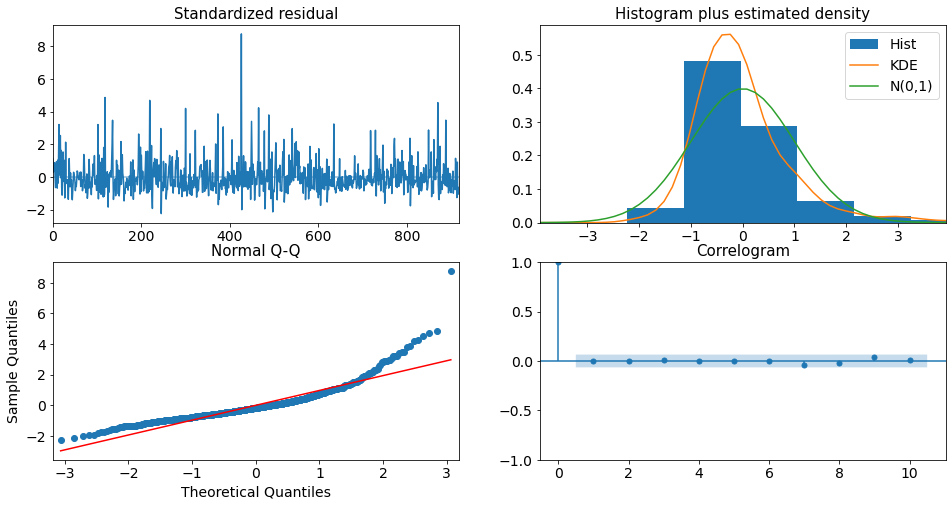

In [38]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

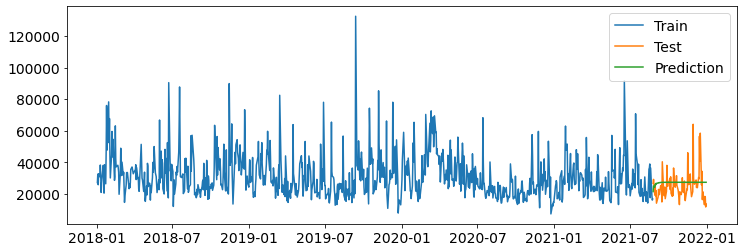

In [39]:
# 테스트 데이터 개수만큼 예측
y_predict = model.predict(n_periods=len(y_test)) 
y_predict = pd.DataFrame(y_predict,columns=['Prediction'])
y_predict.index = y_test.index
# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train, label='Train')        # 훈련 데이터
plt.plot(y_test, label='Test')          # 테스트 데이터
plt.plot(y_predict, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

In [40]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [41]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in y_test.sales:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    model.update(new_ob)

In [42]:
pd.DataFrame({"test": y_test.sales, "pred": y_pred})

,test,pred
date,,
2021-08-26,26639.0,21411.381825
2021-08-27,29133.0,26781.287657
2021-08-30,19227.0,25918.331921
2021-08-31,25471.0,25204.643845
2021-09-01,18723.0,25648.037352
...,...,...
2021-12-27,13061.0,27422.578866
2021-12-28,18336.0,20068.441580
2021-12-29,17855.0,24135.040619


In [43]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1008
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -10869.286
Date:                Tue, 29 Nov 2022   AIC                          21750.571
Time:                        04:55:14   BIC                          21780.060
Sample:                             0   HQIC                         21761.775
                               - 1008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0220      0.208     -0.106      0.916      -0.430       0.386
ar.L2          0.5464      0.122      4.469      0.000       0.307       0.786
ma.L1         -0.6379      0.207     -3.076      0.0

In [44]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = y_train.index, y = y_train.sales, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_test.sales, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = y_test.index.tolist() + y_test.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(0,1,0)모형")
fig.show()

#### __아래 코드 실패지만 개선의 여지는 있음__
* 값이 빠르게 하나로 수렴하고 상당히 오랜 시간이 걸림
* 실측 데이터가 있는 경우 매일매일 모델을 업데이트하면서 나아갔으나 실측 데이터가 없어서 빠르게 수렴한 것이 아닐까하는 추측

```python
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )
def arima_forecast(train, test):
    ids = list(train['product_id'].unique())
    sub = pd.DataFrame()
    
    for i in tqdm(ids):
        temp_train = train[train['product_id']==i]
        temp_test = test[test['product_id']==i]
        temp = pd.concat([temp_train, temp_test], axis=0)
#         temp.drop(['product_id','id'],axis=1, inplace=True)
#         y_train, y_test = train_test_split(cc, test_size = 0.2, shuffle = False)
        y_train = temp[pd.isnull(temp['id'])]
        y_test = temp[~pd.isnull(temp['id'])]
        last = y_test.copy()
        y_train.drop(['product_id','id'],axis=1, inplace=True)
        y_test.drop(['product_id','id'],axis=1, inplace=True)
        y_train = y_train.set_index('date')
        y_test = y_test.set_index('date')
        kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
        adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
        n_diffs = max(adf_diffs, kpss_diffs)
        
        model = pm.auto_arima (y_train, d = n_diffs, seasonal = False, trace = True)
        model.fit(y_train)
        # 테스트 데이터 개수만큼 예측
        y_predict = model.predict(n_periods=len(y_test)) 
        print(y_predict)
        y_predict = pd.DataFrame(y_predict,columns=['Prediction'])
        y_predict.index = y_test.index
        display(y_predict)
        forecasts = []
        y_pred = []
        pred_upper = []
        pred_lower = []
         
        for index in range(len(y_test.sales)):
            fc, conf = forecast_one_step()
            print(fc)
            y_pred.append(fc)
            pred_upper.append(conf[1])
            pred_lower.append(conf[0])
            ## 모형 업데이트 !!
            model.update(y_pred[index])
        print(type(y_pred), len(y_pred))
#         print(len(y_pred[len(y_pred)-len(temp_test)]), print(temp_test.shape[0]))
        print(y_pred)
        display(last)
        last['sales'] = y_pred
        display(last)
#         last = last[~pd.isnull(last['id'])]
        display(last)
        sub = pd.concat([sub,last[['id','sales']]])
        display(sub)
    return sub
```

In [45]:
# arima_predict = arima_forecast(train, test)
# arima_predict.to_csv('arima_predict.csv', index=False)

# 3. Train Data Feature
* product_id별 category에서 특별한 공통점을 찾지 못하였음.
* 시간을 쪼개어서 feature로 활용하여 id별로 xgboost를 통해서 학습하고 예측한다.

In [46]:
temp_data.drop('diff_sales', axis=1, inplace=True)
temp_data.head()

,date,product_id,sales
0,2018-01-02,184,47835.0
1,2018-01-03,184,68791.0
2,2018-01-04,184,59432.0
3,2018-01-05,184,74285.0
4,2018-01-08,184,61176.0


In [47]:
date = temp_data.date
temp_data['year'] = date.dt.year
temp_data['month'] = date.dt.month
temp_data['weekday'] = date.dt.weekday
temp_data['week'] = date.dt.isocalendar().week
temp_data['week'] = list(map(int, temp_data['week']))
temp_data['weekofyear'] = date.dt.weekofyear
temp_data['quarter'] = date.dt.quarter
temp_data['dayofyear'] = date.dt.dayofyear
temp_data.head()

,date,product_id,sales,year,month,weekday,week,weekofyear,quarter,dayofyear
0,2018-01-02,184,47835.0,2018,1,1,1,1,1,2
1,2018-01-03,184,68791.0,2018,1,2,1,1,1,3
2,2018-01-04,184,59432.0,2018,1,3,1,1,1,4
3,2018-01-05,184,74285.0,2018,1,4,1,1,1,5
4,2018-01-08,184,61176.0,2018,1,0,2,2,1,8


In [48]:
data_features = list(temp_data.columns)

<AxesSubplot:>

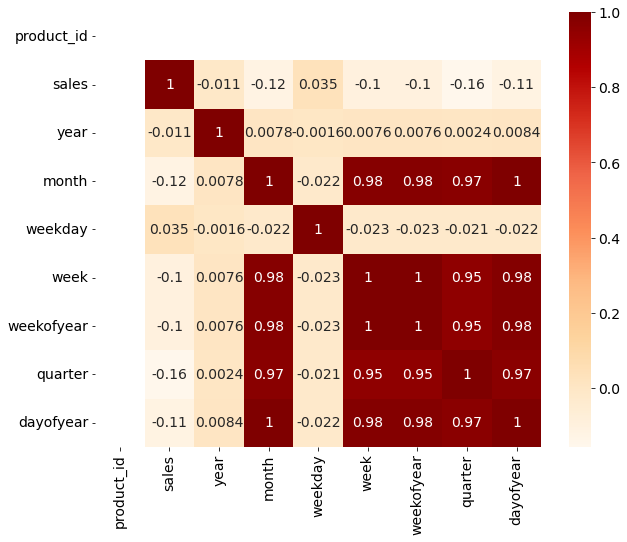

In [49]:
plt.figure(figsize=(10, 8))
cont_corr = temp_data[data_features].corr()    # 연속형 피처 간 상관관계
sns.heatmap(cont_corr, annot=True, cmap='OrRd') # 히트맵 그리기

> month와 week, weekofyear, quearter, dayofyear는 아주 높은 상관관계를 가지기 때문에 month를 제외하고 나머지는 사용하지 않는다.

In [50]:
result = seasonal_decompose(temp_data.sales, model='additive', two_sided=True, 
                            period=20, extrapolate_trend='freq')
mu, std = result.resid.mean(), result.resid.std()
outlier = temp_data.date[result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)].index].index
temp_data.date[result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

86     2018-05-07
160    2018-08-21
254    2019-01-07
255    2019-01-08
290    2019-02-28
349    2019-05-23
410    2019-08-20
496    2019-12-20
534    2020-02-18
560    2020-03-25
719    2020-11-09
747    2020-12-18
788    2021-02-19
917    2021-08-24
955    2021-10-18
985    2021-11-30
994    2021-12-13
996    2021-12-15
997    2021-12-16
998    2021-12-17
1005   2021-12-29
1006   2021-12-30
1007   2021-12-31
Name: date, dtype: datetime64[ns]

In [51]:
fig = px.line(temp_data, x='date', y="sales")
fig.show()

In [52]:
def predict_xgboost_by_date(train, test, way):
    '''
    train : train data
    test : test data
    way : 'remove' or 'mean'
    '''
    ids = list(train['product_id'].unique())
    sub = pd.DataFrame()
    for i in tqdm(ids):
        temp_train = train[train['product_id']==i]
        temp_test = test[test['product_id']==i]
        
        date = pd.to_datetime(temp_train.date)
        temp_train['year'] = date.dt.year
        temp_train['month'] = date.dt.month
        temp_train['day'] = date.dt.weekday


        date = pd.to_datetime(temp_test.date)
        temp_test['year'] = date.dt.year
        temp_test['month'] = date.dt.month
        temp_test['day'] = date.dt.weekday

        
        # sales 이상치 제거
        result = seasonal_decompose(temp_train.sales, model='additive', two_sided=True, 
                            period=20, extrapolate_trend='freq')
        mu, std = result.resid.mean(), result.resid.std() # 잔차 평균과 분산
        outlier = temp_train.date[result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)].index].index
        if way == 'remove':
            temp_train.drop(outlier, inplace=True) # outlier를 제거해줌
        elif way=='mean':
            delete_outlier = temp_train.drop(outlier)
            for i in outlier:
                temp_train.at[i,'sales'] = delete_outlier.sales.mean()
        tr = temp_train[['product_id','year','day','month']]
        label = temp_train['sales']
        te = temp_test[['product_id','year','day','month']]
        xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
        xgb.fit(tr,label)
        xgb_pred = xgb.predict(te)
        
        temp_test['sales'] = xgb_pred.tolist()
        sub = pd.concat([sub,temp_test[['id','sales']]])
    return sub

In [53]:
train = train.fillna(0)
outlier_mean = predict_xgboost_by_date(train,test, 'mean')
outlier_mean.to_csv('outlier_mean.csv', index=False)

  0%|          | 0/491 [00:00<?, ?it/s]

# 4. xgboost gridsearchCV 적용

In [54]:
grid = train[train['product_id']==1]

date = pd.to_datetime(grid.date)
grid['year'] = date.dt.year
grid['month'] = date.dt.month
grid['day'] = date.dt.weekday

result = seasonal_decompose(grid.sales, model='additive', two_sided=True, 
                    period=20, extrapolate_trend='freq')
mu, std = result.resid.mean(), result.resid.std() # 잔차 평균과 분산
outlier = grid.date[result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)].index].index

delete_outlier = grid.drop(outlier)
for i in outlier:
    grid.at[i,'sales'] = delete_outlier.sales.mean()

grid_train = grid[:-62]
grid_test = grid[grid_train.shape[0]:]

In [55]:
grid_train = grid[['product_id','year','day','month']]
grid_label = grid['sales']

In [56]:
xgboost.XGBRegressor()

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)

```python
from sklearn.model_selection import KFold, GridSearchCV

xgb1 = xgboost.XGBRegressor()
parameters = {'nthread':[4], 
              'learning_rate': [0.03, 0.05, 0.08, 0.3, 0.5, 1],
              'max_depth': [5, 6, 7, 10],
              'subsample': [0.4, 0.75],
              'colsample_bytree': [0.3, 0.5, 0.7],
              'n_estimators': [100, 300, 500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(grid_train,
         grid_label)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

"""
-0.3535426718470587
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 500, 'nthread': 4, 'subsample': 0.75}
"""
```

In [57]:
def predict_xgboost_by_date2(train, test, way):
    '''
    train : train data
    test : test data
    way : 'remove' or 'mean'
    '''
    ids = list(train['product_id'].unique())
    sub = pd.DataFrame()
    for i in tqdm(ids):
        temp_train = train[train['product_id']==i]
        temp_test = test[test['product_id']==i]
        
        date = pd.to_datetime(temp_train.date)
        temp_train['year'] = date.dt.year
        temp_train['month'] = date.dt.month
        temp_train['day'] = date.dt.weekday


        date = pd.to_datetime(temp_test.date)
        temp_test['year'] = date.dt.year
        temp_test['month'] = date.dt.month
        temp_test['day'] = date.dt.weekday

        
        # sales 이상치 제거
        result = seasonal_decompose(temp_train.sales, model='additive', two_sided=True, 
                            period=20, extrapolate_trend='freq')
        mu, std = result.resid.mean(), result.resid.std() # 잔차 평균과 분산
        outlier = temp_train.date[result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)].index].index
        if way == 'remove':
            temp_train.drop(outlier, inplace=True) # outlier를 제거해줌
        elif way=='mean':
            delete_outlier = temp_train.drop(outlier)
            for i in outlier:
                temp_train.at[j,'sales'] = delete_outlier.sales.mean()
        tr = temp_train[['product_id','year','day','month']]
        label = temp_train['sales']
        te = temp_test[['product_id','year','day','month']]
        xgb = xgboost.XGBRegressor(n_estimators=500, learning_rate=0.03, subsample=0.75, max_depth=5)
        xgb.fit(tr,label)
        xgb_pred = xgb.predict(te)
        
        temp_test['sales'] = xgb_pred.tolist()
        sub = pd.concat([sub,temp_test[['id','sales']]])
    return sub

In [58]:
outlier_mean_simple_gridsearch = predict_xgboost_by_date(train,test, 'mean')
outlier_mean_simple_gridsearch.to_csv('outlier_mean_simple_gridsearch.csv', index=False)

  0%|          | 0/491 [00:00<?, ?it/s]

In [59]:
outlier_remove_simple_gridsearch = predict_xgboost_by_date(train,test, 'remove')
outlier_remove_simple_gridsearch.to_csv('outlier_remove_simple_gridsearch.csv', index=False)

  0%|          | 0/491 [00:00<?, ?it/s]

## 4.1 같은 기간의 데이터만 사용한다면?
* test data의 기간은 1월부터 3월까지
* train의 데이터도 1~3월까지만 사용한다면 어떨까?

In [60]:
def predict_only_same_test(train, test, way):
    '''
    train : train data
    test : test data
    way : 'remove' or 'mean'
    '''
    ids = list(train['product_id'].unique())
    sub = pd.DataFrame()
#     print(ids)
    for i in tqdm(ids):
        temp_train = train[train['product_id']==i]
        temp_test = test[test['product_id']==i]
        
        date = pd.to_datetime(temp_train.date)
        temp_train['year'] = date.dt.year
        temp_train['month'] = date.dt.month
        temp_train['day'] = date.dt.weekday


        date = pd.to_datetime(temp_test.date)
        temp_test['year'] = date.dt.year
        temp_test['month'] = date.dt.month
        temp_test['day'] = date.dt.weekday

        
        # sales 이상치 제거
        result = seasonal_decompose(temp_train.sales, model='additive', two_sided=True, 
                            period=20, extrapolate_trend='freq')
        mu, std = result.resid.mean(), result.resid.std() # 잔차 평균과 분산
        outlier = temp_train.date[result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)].index].index
        if way == 'remove':
            temp_train.drop(outlier, inplace=True) # outlier를 제거해줌
        elif way=='mean':
            delete_outlier = temp_train.drop(outlier)
            for j in outlier:
                temp_train.at[j,'sales'] = delete_outlier.sales.mean()
        if i != 43:       # product_id 43은 21년 5월 이후 데이터 밖에 없으니 제외
            temp_train = temp_train[temp_train['month']<4]
        tr = temp_train[['product_id','year','day','month']]
        label = temp_train['sales']
        te = temp_test[['product_id','year','day','month']]
        xgb = xgboost.XGBRegressor(n_estimators=500, learning_rate=0.03, subsample=0.75, max_depth=5)
        xgb.fit(tr,label)
        xgb_pred = xgb.predict(te)
        
        temp_test['sales'] = xgb_pred.tolist()
        sub = pd.concat([sub,temp_test[['id','sales']]])
    return sub

In [61]:
same_date_predict = predict_only_same_test(train, test, 'mean')
same_date_predict.to_csv("same_date_predict.csv", index=False)

  0%|          | 0/491 [00:00<?, ?it/s]

# 5. 결론
1. product의 category들을 제대로 활용하지 못하였기 때문에 이 부분에 대한 아이디어가 필요함
2. 단순하게 One-Hot encoding이나 LabelEncoding을 사용하지 않은 이유는 카테고리가 동일하다고 해서 비슷한 판매량을 가진 것도 아니었으며 비슷한 판매특성을 보여주지 않아서 개별로 학습을 진행해야겠다고 생각하였음
3. 결과적으로 다양한 피처에 대한 아이디어를 내지 못하고 단순하게 시간데이터를 따로 뽑아서 활용하는 정도로 진행하였으며 어느정도 예측은 되었음.
4. ARIMA 모델의 경우 슬라이딩 윈도우 기법을 통해 step을 밟아나가면 유의미하게 예측이 성공했으나 하나의 모델로만 진행하면 예측이 안됨.  
   --> predict값을 넣고 모델을 지속적으로 학습하였지만 금세 하나의 값으로 수렴하는 문제가 발생하였음. 시간적인 문제까지 포함하여 결국 ARIMA 모델 사용X
5. xgboost를 사용한 것은 머신러닝 알고리즘 중에서 성능이 좋은 편에 속하였고 Feature Engineering을 많이 진행된 것이 아니었기 때문에 다른 모델들과 비교해서 차이가 크지 않을 것이라고 생각하였음.
6. product별로 예측을 하다보니 데이터 수가 적어서 과적합 발생 문제가 발생하였을 것이라고 생각함.
7. DL의 경우도 생각해보았으나 시계열 데이터에 대한 그래프와 경향 속에서 insight를 찾는 것이 더 중요하다고 판단하여 사용하지 않았음.
8. SMAPE 값을 줄이고자 노력하였으나 의미있었던 것은 outlier들의 값을 제거하는 것보다는 outlier를 제외한 값들의 평균값으로 넣어서 학습시킨 것이었음.